<a href="https://colab.research.google.com/github/IVineetPandey/ML_Projects/blob/main/DAFL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_federated as tff
import numpy as np
import collections

ERROR:jax._src.xla_bridge:Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/xla_bridge.py", line 438, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/usr/local/lib/python3.11/dist-packages/jax_plugins/xla_cuda12/__init__.py", line 85, in initialize
    options = xla_client.generate_pjrt_gpu_plugin_options()
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: module 'jaxlib.xla_client' has no attribute 'generate_pjrt_gpu_plugin_options'


In [4]:


import collections
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [5]:

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()


x_train, x_test = x_train / 255.0, x_test / 255.0


x_train = x_train.reshape(-1, 784).astype('float32')
x_test = x_test.reshape(-1, 784).astype('float32')


y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [6]:

def create_clients(x, y, num_clients=10):
    clients_data = collections.OrderedDict()
    data_per_client = len(x) // num_clients

    for i in range(num_clients):
        start = i * data_per_client
        end = (i + 1) * data_per_client
        clients_data[f'client_{i+1}'] = (x[start:end], y[start:end])

    return clients_data


clients_train = create_clients(x_train, y_train, num_clients=10)
clients_test = create_clients(x_test, y_test, num_clients=10)


In [7]:

def preprocess(dataset):
    return tf.data.Dataset.from_tensor_slices(dataset).shuffle(1000).batch(32)


federated_train_data = [preprocess(clients_train[client]) for client in clients_train]
federated_test_data = [preprocess(clients_test[client]) for client in clients_test]


In [8]:
def create_federated_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(784,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    return tff.learning.models.from_keras_model(
        model,
        input_spec=federated_train_data[0].element_spec,
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=[tf.keras.metrics.CategoricalAccuracy()]
    )


In [9]:
import tensorflow_federated as tff
import tensorflow as tf


def create_federated_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(784,)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    return tff.learning.models.from_keras_model(
        keras_model=model,
        input_spec=(
            tf.TensorSpec(shape=[None, 784], dtype=tf.float32),
            tf.TensorSpec(shape=[None, 10], dtype=tf.float32)
        ),
        loss=tf.keras.losses.CategoricalCrossentropy(),
        metrics=[tf.keras.metrics.CategoricalAccuracy()]
    )


client_optimizer_fn = tff.learning.optimizers.build_sgdm(learning_rate=0.01)
server_optimizer_fn = tff.learning.optimizers.build_sgdm(learning_rate=0.01)


iterative_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn=create_federated_model,
    client_optimizer_fn=client_optimizer_fn,
    server_optimizer_fn=server_optimizer_fn
)


state = iterative_process.initialize()



In [10]:
NUM_ROUNDS = 50

state, metrics = iterative_process.next(state, federated_train_data)
print(metrics)

OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('categorical_accuracy', 0.5805333), ('loss', 1.6658453), ('num_examples', 60000), ('num_batches', 1880)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])


In [11]:
NUM_ROUNDS = 50

for round_num in range(1, NUM_ROUNDS + 1):
    state, metrics = iterative_process.next(state, federated_train_data)


    train_accuracy = metrics["client_work"]["train"]["categorical_accuracy"]

    print(f'Round {round_num}, Train Accuracy: {train_accuracy:.4f}')

Round 1, Train Accuracy: 0.5881
Round 2, Train Accuracy: 0.5955
Round 3, Train Accuracy: 0.6000
Round 4, Train Accuracy: 0.6046
Round 5, Train Accuracy: 0.6123
Round 6, Train Accuracy: 0.6191
Round 7, Train Accuracy: 0.6242
Round 8, Train Accuracy: 0.6292
Round 9, Train Accuracy: 0.6339
Round 10, Train Accuracy: 0.6410
Round 11, Train Accuracy: 0.6454
Round 12, Train Accuracy: 0.6502
Round 13, Train Accuracy: 0.6550
Round 14, Train Accuracy: 0.6594
Round 15, Train Accuracy: 0.6643
Round 16, Train Accuracy: 0.6681
Round 17, Train Accuracy: 0.6737
Round 18, Train Accuracy: 0.6784
Round 19, Train Accuracy: 0.6826
Round 20, Train Accuracy: 0.6867
Round 21, Train Accuracy: 0.6888
Round 22, Train Accuracy: 0.6943
Round 23, Train Accuracy: 0.6982
Round 24, Train Accuracy: 0.6999
Round 25, Train Accuracy: 0.7029
Round 26, Train Accuracy: 0.7071
Round 27, Train Accuracy: 0.7103
Round 28, Train Accuracy: 0.7125
Round 29, Train Accuracy: 0.7150
Round 30, Train Accuracy: 0.7200
Round 31, Train Acc

In [12]:

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)
federated_test_data = [test_dataset]


evaluation_process = tff.learning.algorithms.build_fed_eval(model_fn=create_federated_model)


evaluation_state = evaluation_process.initialize()


evaluation_state, eval_metrics = evaluation_process.next(evaluation_state, federated_test_data)


print("Evaluation Metrics:", eval_metrics)


test_accuracy = eval_metrics["client_work"]["eval"]["current_round_metrics"]["categorical_accuracy"]
print(f'Test Accuracy: {test_accuracy:.4f}')




Evaluation Metrics: OrderedDict([('distributor', ()), ('client_work', OrderedDict([('eval', OrderedDict([('current_round_metrics', OrderedDict([('categorical_accuracy', 0.0943), ('loss', 2.3567872), ('num_examples', 10000), ('num_batches', 313)])), ('total_rounds_metrics', OrderedDict([('categorical_accuracy', 0.0943), ('loss', 2.3567872), ('num_examples', 10000), ('num_batches', 313)]))]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])
Test Accuracy: 0.0943


In [13]:
print(metrics)

OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('categorical_accuracy', 0.7610667), ('loss', 1.2182505), ('num_examples', 60000), ('num_batches', 1880)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])


Round 1, Train Accuracy: 0.7633, Loss: 1.2121
Round 2, Train Accuracy: 0.7645, Loss: 1.2054
Round 3, Train Accuracy: 0.7665, Loss: 1.1991
Round 4, Train Accuracy: 0.7669, Loss: 1.1932
Round 5, Train Accuracy: 0.7691, Loss: 1.1873
Round 6, Train Accuracy: 0.7711, Loss: 1.1811
Round 7, Train Accuracy: 0.7714, Loss: 1.1752
Round 8, Train Accuracy: 0.7749, Loss: 1.1696
Round 9, Train Accuracy: 0.7740, Loss: 1.1638
Round 10, Train Accuracy: 0.7756, Loss: 1.1577
Round 11, Train Accuracy: 0.7768, Loss: 1.1522
Round 12, Train Accuracy: 0.7780, Loss: 1.1466
Round 13, Train Accuracy: 0.7796, Loss: 1.1411
Round 14, Train Accuracy: 0.7814, Loss: 1.1353
Round 15, Train Accuracy: 0.7821, Loss: 1.1301
Round 16, Train Accuracy: 0.7826, Loss: 1.1248
Round 17, Train Accuracy: 0.7842, Loss: 1.1194
Round 18, Train Accuracy: 0.7855, Loss: 1.1142
Round 19, Train Accuracy: 0.7858, Loss: 1.1092
Round 20, Train Accuracy: 0.7871, Loss: 1.1038
Round 21, Train Accuracy: 0.7885, Loss: 1.0986
Round 22, Train Accura

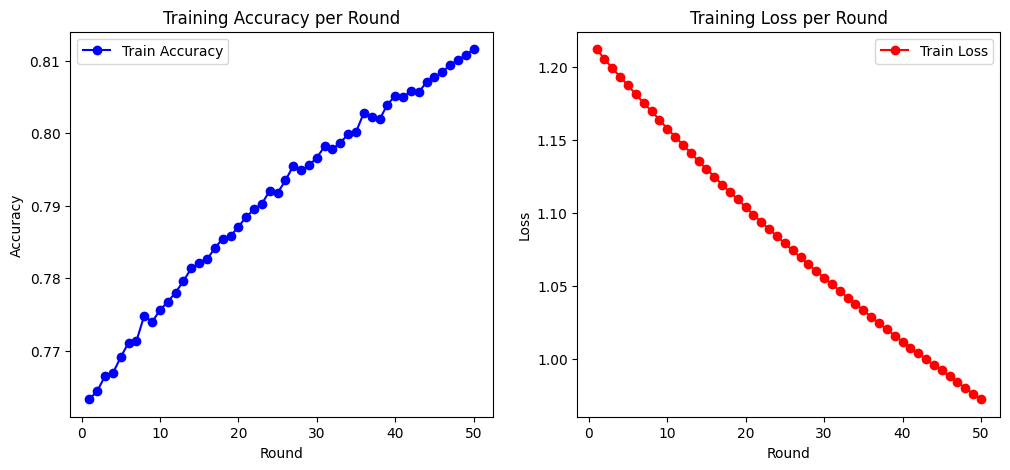

In [14]:

train_acc_list = []
train_loss_list = []
rounds = list(range(1, NUM_ROUNDS + 1))

for round_num in rounds:
    state, metrics = iterative_process.next(state, federated_train_data)

    train_acc = metrics["client_work"]["train"]["categorical_accuracy"]
    train_loss = metrics["client_work"]["train"]["loss"]

    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)

    print(f'Round {round_num}, Train Accuracy: {train_acc:.4f}, Loss: {train_loss:.4f}')


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(rounds, train_acc_list, marker='o', linestyle='-', color='b', label='Train Accuracy')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.title('Training Accuracy per Round')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(rounds, train_loss_list, marker='o', linestyle='-', color='r', label='Train Loss')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.title('Training Loss per Round')
plt.legend()

plt.show()


In [15]:

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)
federated_test_data = [test_dataset]


evaluation_process = tff.learning.algorithms.build_fed_eval(model_fn=create_federated_model)


evaluation_state = evaluation_process.initialize()

test_acc_list = []
test_loss_list = []
num_eval_rounds = 10

for round_num in range(1, num_eval_rounds + 1):
    evaluation_state, eval_metrics = evaluation_process.next(evaluation_state, federated_test_data)


    test_accuracy = eval_metrics["client_work"]["eval"]["current_round_metrics"]["categorical_accuracy"]
    test_loss = eval_metrics["client_work"]["eval"]["current_round_metrics"]["loss"]

    test_acc_list.append(test_accuracy)
    test_loss_list.append(test_loss)

    print(f'Evaluation Round {round_num}, Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss:.4f}')


Evaluation Round 1, Test Accuracy: 0.1084, Test Loss: 2.4173
Evaluation Round 2, Test Accuracy: 0.1084, Test Loss: 2.4173
Evaluation Round 3, Test Accuracy: 0.1084, Test Loss: 2.4173
Evaluation Round 4, Test Accuracy: 0.1084, Test Loss: 2.4173
Evaluation Round 5, Test Accuracy: 0.1084, Test Loss: 2.4173
Evaluation Round 6, Test Accuracy: 0.1084, Test Loss: 2.4173
Evaluation Round 7, Test Accuracy: 0.1084, Test Loss: 2.4173
Evaluation Round 8, Test Accuracy: 0.1084, Test Loss: 2.4173
Evaluation Round 9, Test Accuracy: 0.1084, Test Loss: 2.4173
Evaluation Round 10, Test Accuracy: 0.1084, Test Loss: 2.4173


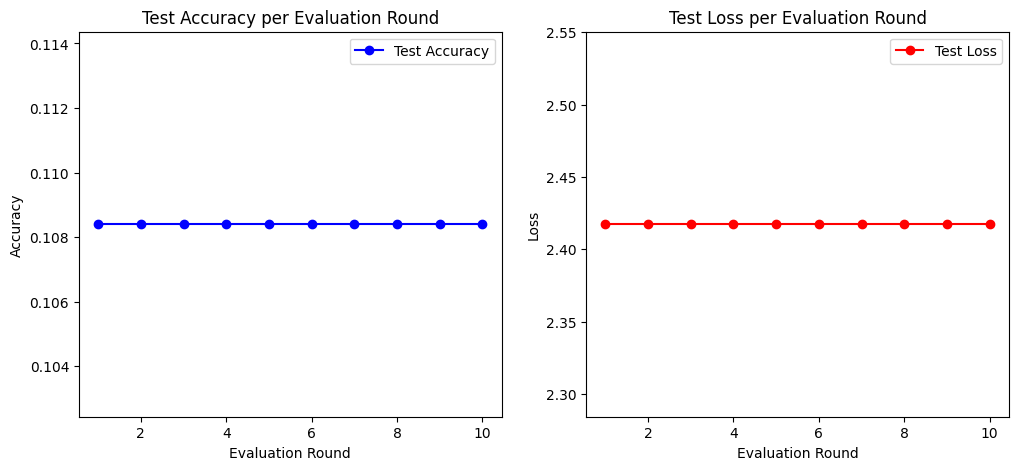

In [16]:
import matplotlib.pyplot as plt

rounds = list(range(1, num_eval_rounds + 1))

plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(rounds, test_acc_list, marker='o', linestyle='-', color='b', label='Test Accuracy')
plt.xlabel('Evaluation Round')
plt.ylabel('Accuracy')
plt.title('Test Accuracy per Evaluation Round')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(rounds, test_loss_list, marker='o', linestyle='-', color='r', label='Test Loss')
plt.xlabel('Evaluation Round')
plt.ylabel('Loss')
plt.title('Test Loss per Evaluation Round')
plt.legend()

plt.show()


In [17]:
import matplotlib.pyplot as plt

# Convert test dataset to TFF format
test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)
federated_test_data = [test_dataset]  # Wrap in a list

# Build evaluation process
evaluation_process = tff.learning.algorithms.build_fed_eval(model_fn=create_federated_model)

# Initialize evaluation state
evaluation_state = evaluation_process.initialize()

# Run evaluation
evaluation_state, eval_metrics = evaluation_process.next(evaluation_state, federated_test_data)

# Extract test accuracy and loss
test_accuracy = eval_metrics["client_work"]["eval"]["current_round_metrics"]["categorical_accuracy"]
test_loss = eval_metrics["client_work"]["eval"]["current_round_metrics"]["loss"]

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


Test Accuracy: 0.1260
Test Loss: 2.3420


Round 1, Train Accuracy: 0.5807, Loss: 1.6661
Round 2, Train Accuracy: 0.5872, Loss: 1.6539
Round 3, Train Accuracy: 0.5929, Loss: 1.6421
Round 4, Train Accuracy: 0.6003, Loss: 1.6304
Round 5, Train Accuracy: 0.6055, Loss: 1.6186
Round 6, Train Accuracy: 0.6112, Loss: 1.6072
Round 7, Train Accuracy: 0.6187, Loss: 1.5959
Round 8, Train Accuracy: 0.6227, Loss: 1.5846
Round 9, Train Accuracy: 0.6298, Loss: 1.5737
Round 10, Train Accuracy: 0.6341, Loss: 1.5626
Round 11, Train Accuracy: 0.6400, Loss: 1.5523
Round 12, Train Accuracy: 0.6453, Loss: 1.5414
Round 13, Train Accuracy: 0.6516, Loss: 1.5310
Round 14, Train Accuracy: 0.6556, Loss: 1.5205
Round 15, Train Accuracy: 0.6620, Loss: 1.5104
Round 16, Train Accuracy: 0.6656, Loss: 1.5005
Round 17, Train Accuracy: 0.6695, Loss: 1.4905
Round 18, Train Accuracy: 0.6742, Loss: 1.4800
Round 19, Train Accuracy: 0.6787, Loss: 1.4709
Round 20, Train Accuracy: 0.6831, Loss: 1.4611
Round 21, Train Accuracy: 0.6871, Loss: 1.4516
Round 22, Train Accura

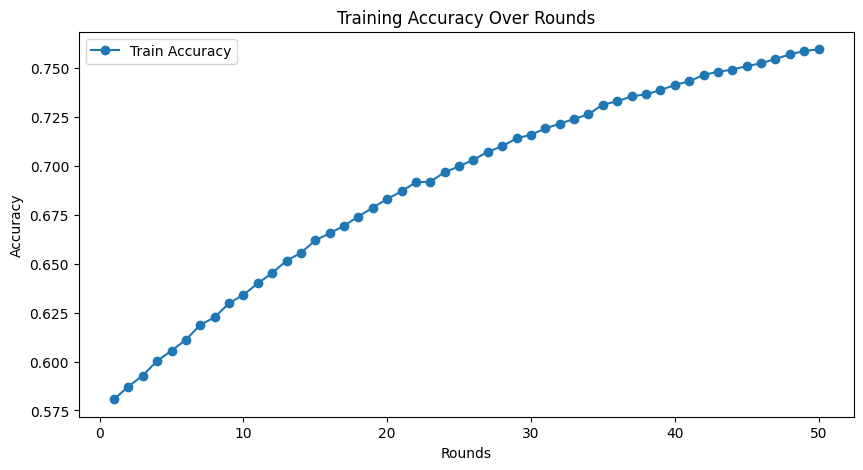

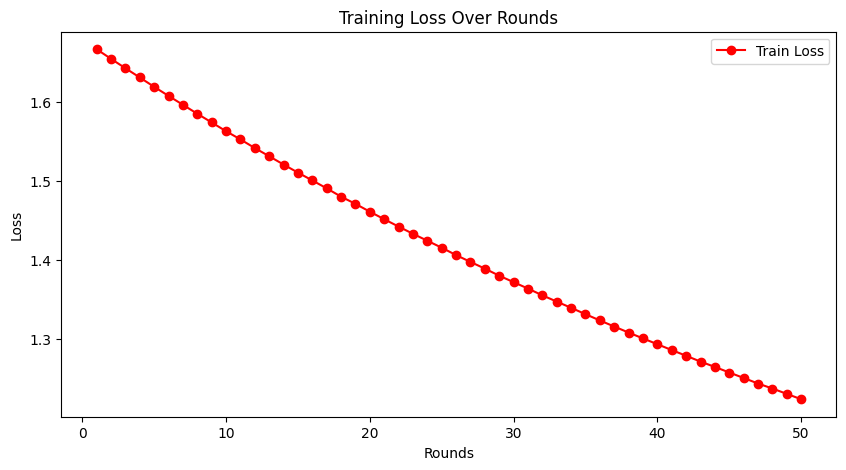

In [23]:
import matplotlib.pyplot as plt

# Define lists to store training accuracy and loss
train_accuracy = []
training_losses = []

# Training rounds
NUM_ROUNDS = 50
rounds = list(range(1, NUM_ROUNDS + 1))

# Train the federated model and store metrics
state = iterative_process.initialize()

for round_num in rounds:
    state, metrics = iterative_process.next(state, federated_train_data)

    # Extract accuracy and loss values
    accuracy = metrics['client_work']['train']['categorical_accuracy']
    loss = metrics['client_work']['train']['loss']

    # Store in lists
    train_accuracy.append(accuracy)
    training_losses.append(loss)

    print(f'Round {round_num}, Train Accuracy: {accuracy:.4f}, Loss: {loss:.4f}')

# Plot Training Accuracy
plt.figure(figsize=(10, 5))
plt.plot(rounds, train_accuracy, label='Train Accuracy', marker='o', linestyle='-')
plt.xlabel("Rounds")
plt.ylabel("Accuracy")
plt.title("Training Accuracy Over Rounds")
plt.legend()
plt.show()

# Plot Training Loss
plt.figure(figsize=(10, 5))
plt.plot(rounds, training_losses, label='Train Loss', marker='o', linestyle='-', color='red')
plt.xlabel("Rounds")
plt.ylabel("Loss")
plt.title("Training Loss Over Rounds")
plt.legend()
plt.show()



Test Round 1, Test Accuracy: 0.1260, Loss: 2.3420
Test Round 2, Test Accuracy: 0.1260, Loss: 2.3420
Test Round 3, Test Accuracy: 0.1260, Loss: 2.3420
Test Round 4, Test Accuracy: 0.1260, Loss: 2.3420
Test Round 5, Test Accuracy: 0.1260, Loss: 2.3420
Test Round 6, Test Accuracy: 0.1260, Loss: 2.3420
Test Round 7, Test Accuracy: 0.1260, Loss: 2.3420
Test Round 8, Test Accuracy: 0.1260, Loss: 2.3420
Test Round 9, Test Accuracy: 0.1260, Loss: 2.3420
Test Round 10, Test Accuracy: 0.1260, Loss: 2.3420


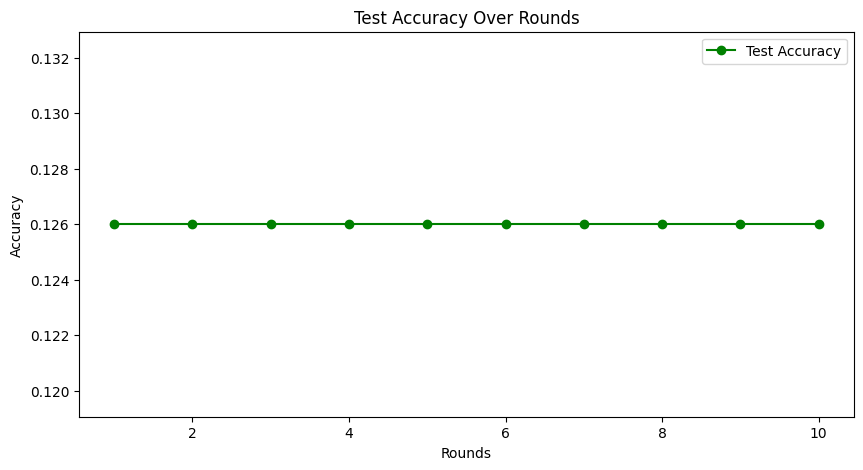

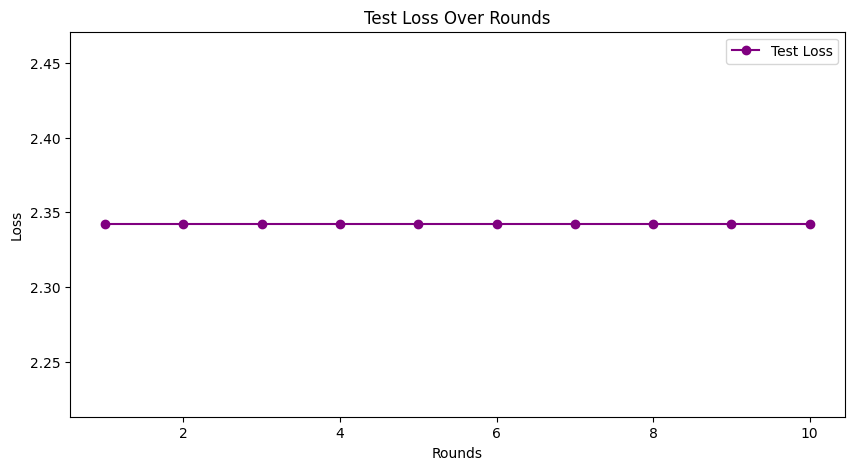

In [24]:
import matplotlib.pyplot as plt


test_accuracies = []
test_losses = []


NUM_TEST_ROUNDS = 10


evaluation_state = evaluation_process.initialize()

for round_num in range(1, NUM_TEST_ROUNDS + 1):
    evaluation_state, eval_metrics = evaluation_process.next(evaluation_state, federated_test_data)


    accuracy = eval_metrics['client_work']['eval']['current_round_metrics']['categorical_accuracy']
    loss = eval_metrics['client_work']['eval']['current_round_metrics']['loss']


    test_accuracies.append(accuracy)
    test_losses.append(loss)

    print(f'Test Round {round_num}, Test Accuracy: {accuracy:.4f}, Loss: {loss:.4f}')


test_rounds = list(range(1, len(test_accuracies) + 1))


plt.figure(figsize=(10, 5))
plt.plot(test_rounds, test_accuracies, label='Test Accuracy', marker='o', linestyle='-', color='green')
plt.xlabel("Rounds")
plt.ylabel("Accuracy")
plt.title("Test Accuracy Over Rounds")
plt.legend()
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(test_rounds, test_losses, label='Test Loss', marker='o', linestyle='-', color='purple')
plt.xlabel("Rounds")
plt.ylabel("Loss")
plt.title("Test Loss Over Rounds")
plt.legend()
plt.show()


In [28]:
keras_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               100480    
                                                                 
 dense_5 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101770 (397.54 KB)
Trainable params: 101770 (397.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [29]:
trained_model_weights.trainable

[array([[ 0.05950312,  0.03324749, -0.01070379, ..., -0.02573143,
         -0.0024906 ,  0.04932571],
        [-0.03576029,  0.0591059 , -0.05094315, ...,  0.00278319,
         -0.07981499, -0.07231785],
        [ 0.07735658,  0.02938095,  0.04003755, ...,  0.03767366,
         -0.01261662,  0.04769062],
        ...,
        [-0.08061528,  0.06087024,  0.0535545 , ...,  0.06076563,
         -0.03264612, -0.06876788],
        [-0.00960812, -0.05719248,  0.02896315, ..., -0.0502271 ,
         -0.01461034, -0.04482494],
        [-0.04361299,  0.03890578,  0.02563595, ..., -0.0348258 ,
         -0.07934655, -0.03815487]], dtype=float32),
 array([-2.2929902e-03,  8.7244827e-03,  1.0944587e-03, -1.8634754e-03,
        -1.5324935e-03,  2.6325274e-03, -4.5025334e-04, -2.5782953e-03,
         6.9233375e-03,  1.0173185e-02,  5.4122829e-03, -9.5173440e-05,
         4.3282700e-03, -6.7436660e-04,  1.0028713e-03,  3.5889454e-03,
        -1.9964501e-03,  3.9686873e-03,  4.1773631e-03,  7.8732555e-05

313/313 [==============================] - 1s 3ms/step


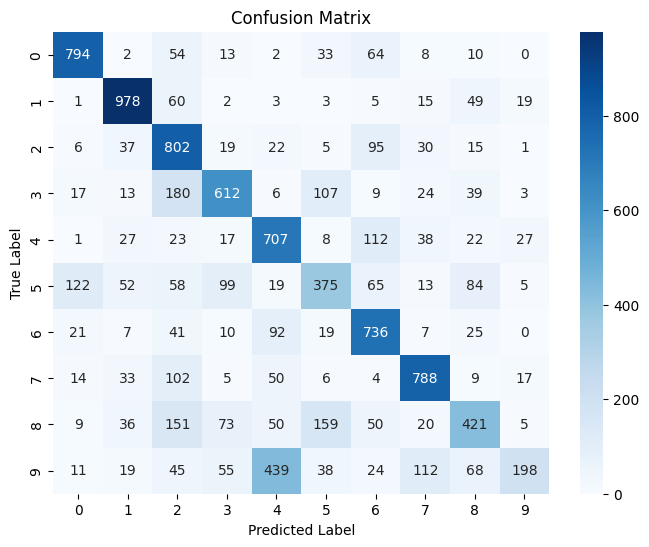

In [31]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


trained_model_weights = iterative_process.get_model_weights(state)


keras_model = create_federated_model()
keras_model = keras_model._keras_model if hasattr(keras_model, "_keras_model") else keras_model


expected_weights = keras_model.get_weights()
extracted_weights = trained_model_weights.trainable

if len(expected_weights) == len(extracted_weights):
    keras_model.set_weights(extracted_weights)
else:
    reshaped_weights = [np.reshape(extracted, expected.shape) for extracted, expected in zip(extracted_weights, expected_weights)]
    keras_model.set_weights(reshaped_weights)


y_pred = keras_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)


if len(y_test.shape) > 1 and y_test.shape[1] > 1:
    y_test = np.argmax(y_test, axis=1)


conf_matrix = confusion_matrix(y_test, y_pred_classes)


plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


